<a target="_blank" href="https://colab.research.google.com/github/datenzauberai/data2day_2023_polars/blob/main/data2day_2023_Polars_Teil_1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Polars: Der Turbo Boost für Dataframes - Teil 3

Wichtige Links zur Erinnerung:

- Homepage von Polars: https://www.pola.rs/
- User-Guide: https://pola-rs.github.io/polars/user-guide/
- API-Referenz: https://pola-rs.github.io/polars/py-polars/html/reference/

## Installation + Vorbereitung

In [1]:
import urllib.request
import os.path

In [ ]:
REQUIREMENTS_URL = "https://github.com/bettercodepaul/data2day_2023_polars/raw/main/requirements.txt"
urllib.request.urlretrieve(REQUIREMENTS_URL, os.path.basename(REQUIREMENTS_URL))

In [ ]:
# nicht vergessen, dass die Laufzeitumgebung ggf. neu gestartet werden muss
!pip install -qr requirements.txt

In [55]:
import polars as pl

In [54]:
# bis zu 60 Zeichen pro Spalte ausgeben und Fließkommazahlen nicht abkürzen
pl.Config(fmt_str_lengths=60, fmt_float="full")

In [57]:
# CSV-Daten herunterladen
CSV_DATA_URL = "https://github.com/bettercodepaul/data2day_2023_polars/releases/download/data-parquet/spotify-charts-2017-2021.parquet"
LOCAL_CSV_DATA_FILE_NAME = os.path.basename(CSV_DATA_URL)
urllib.request.urlretrieve(CSV_DATA_URL, LOCAL_CSV_DATA_FILE_NAME)

('spotify-charts-2017-2021.parquet', <http.client.HTTPMessage at 0x105a04ca0>)

In [56]:
# Parquet-Daten herunterladen
BIG_DATA_URL = "https://github.com/bettercodepaul/data2day_2023_polars/releases/download/data-parquet/spotify-charts-2017-2021.parquet"
LOCAL_BIG_DATA_FILE_NAME = os.path.basename(BIG_DATA_URL)
urllib.request.urlretrieve(BIG_DATA_URL, LOCAL_BIG_DATA_FILE_NAME)

('spotify-charts-2017-2021.parquet', <http.client.HTTPMessage at 0x105a04f40>)

In [ ]:
# Übungen und Hilfsfunktionen herunterladen
EXERCISES_URL = "https://github.com/bettercodepaul/data2day_2023_polars/raw/main/data2day_exercises.py"
urllib.request.urlretrieve(EXERCISES_URL, os.path.basename(EXERCISES_URL))

In [58]:
%load_ext autoreload
%autoreload 2

In [59]:
from data2day_exercises import *

## Lazy vs. Eager

Bis jetzt haben wir Polars immer im "eager mode" benutzt. Jeder Funktionsaufruf hatte direkt eine Operation auf den Daten zur Folge.

Das hat Vorteile beim Debugging von Abfragen, verhindert aber viele Optimierungen, die Polars nur im "lazy mode" nutzen kann.

Für den "lazy mode" gibt es zwei Optionen.

### Eager Load + Lazy Query

Wenn ein Datensatz nicht zu groß ist, können wir ihn vollständig in den Speicher laden, wie wir es schon kennen.

In [77]:
df = pl.read_csv("spotify-charts-2017-2021-global-top200.csv.gz")
type(df)

polars.dataframe.frame.DataFrame

Durch den Aufruf der `lazy` Methode schalten wir dann in den "lazy mode". Die Ausführung der Abfrage ist jetzt angehalten und es wird mit jedem weiteren Aufruf nur die Abfrage "formuliert".

In [115]:
lazy_df = df.lazy()
type(lazy_df)

polars.lazyframe.frame.LazyFrame

In [116]:
# für einen lazy Dataframe wird der unoptimierte Abfragebaum ausgegeben
lazy_df.select("artist", "title").filter(pl.col("artist").eq("Dua Lipa"))

<LazyFrame [2 cols, {"artist": Utf8, "title": Utf8}] at 0x1272A9C00>

Der Plan wird von unten nach oben gelesen. Die griechischen Buchstaben sind aus der relationalen Algebra. Der Buchstabe π steht für die Operation Projektion (`select`), σ für die Operation Selektion (`filter`).

- Table π */9; σ -; bedeutet, dass alle neun Spalten gelesen werden und keine Selektion vorgenommen wird
- π 2/9 bedeutet, dass auf zwei von neun Spalten projiziert wird 
- FILTER BY ist die Selektion aus unserer Abfrage

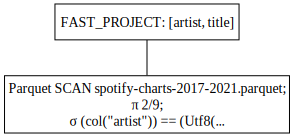

In [117]:
# mit der Methode show_graph() können wir die optimierte Abfrage ausgeben
lazy_df.select("artist", "title").filter(pl.col("artist").eq("Dua Lipa")).show_graph()

Sowohl die Projektion als auch die Selektion passieren im optimierten Abfrageplan früher.

Die Abfrage wird letztendlich ausgeführt, wenn wir die Methode `collect` aufrufen. Das Ergebnis ist dann wieder ein normaler Dataframe.

In [118]:
result = lazy_df.select("artist", "title").filter(pl.col("artist").eq("Dua Lipa")).collect()
result.sample(2)

artist,title
str,str
"""Dua Lipa""","""We're Good"""
"""Dua Lipa""","""New Rules"""


In [119]:
type(result)

polars.dataframe.frame.DataFrame

Durch dieses Vorgehen, kann Polars Optimierungen vor der Ausführung der Abfrage vornehmen.

Eine Auswahl an Optimierungen findet ihr hier: https://pola-rs.github.io/polars/user-guide/lazy/optimizations/

### Lazy Load + Query

Wenn es sich nicht lohnt einen Datensatz vollständig in den Speicher zu laden, können wir auch das Laden der Daten verzögern, in dem wir die IO-Methoden mit dem Namen `scan_*` statt `write_*` nutzen.

Das funktioniert z.B. für Dateien in den Formaten CSV (`scan_csv`) und Parquet (`scan_parquet`), aber nicht für komprimierte CSVs.

Bisher haben wir immer mit einem kleinen Datensatz gearbeitet, der nur die globalen Top-200 Charts beinhaltet (362k Zeilen, 64 MB)

Wir können jetzt auf den richtigen Datensatz wechseln, der die Top-200 und die Viral-50 Charts für 70 verschiedene Regionen enthält (26m Zeilen, 4 GB).

In [120]:
df = pl.scan_parquet("spotify-charts-2017-2021.parquet")

Durch die optimierten Abfragen, werden nur die Daten aus der Datei geladen, die auch wirklich gebraucht werden.

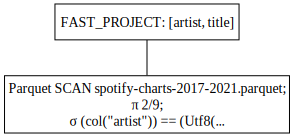

In [123]:
(df
    .select("artist", "title")
    .filter(pl.col("artist").eq("Dua Lipa"))
).show_graph()

Je nach Abfrage können bestimmte Optimierungen nicht durchgeführt werden, weil sie das  Ergebnis verändern würden...

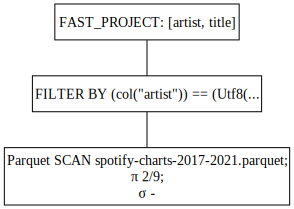

In [124]:
(df
    .head(2)
    .select("artist", "title")
    .filter(pl.col("artist").eq("Dua Lipa"))
).show_graph()

Manchmal lässt der Abfrage-Optimierer auch Potenzial liegen...

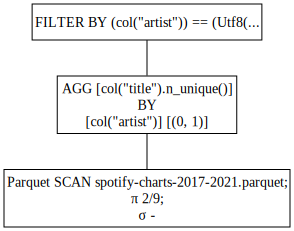

In [127]:
naive_query = (df
    .group_by("artist")
    .agg(pl.col("title").n_unique())
    .filter(pl.col("artist").eq("Dua Lipa"))
)
naive_query.show_graph()

In [128]:
%%timeit
naive_query.collect()

747 ms ± 25.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Wir optimieren händisch, dass zuerst gefiltert werden sollte, was die Abfrage deutlich beschleunigt.

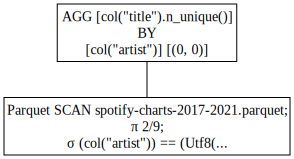

In [129]:
optimized_query = (df
    .filter(pl.col("artist").eq("Dua Lipa"))
    .group_by("artist")
    .agg(pl.col("title").n_unique())
)
optimized_query.show_graph()

In [130]:
%%timeit
optimized_query.collect()

229 ms ± 4.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
